# Introduction to SoccerTrack

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](ここに以下の書式でURLを入れる) 
[![github](https://badgen.net/badge/:status/View%20On%20Github/black?icon=github&label)](https://github.com/AtomScott/SoccerTrack)
[![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=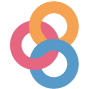)](https://)

---

This quick tutorial introduces the key concepts and basic features of GeoPandas to help you get started with your projects.

## Concepts

### Multiple Object Tracking in SoccerTrack

In a broad definition, Multiple Object Tracking (MOT) is the problem of automatically identifying multiple objects in a video and representing them as a set of trajectories. 

The typical approach to MOT algorithms follows the tracking-by-detection paradigm, which attempts to solve the problem by first detecting objects in each frame and then associating them with the objects in the previous frame.

One large challenge in the tracking-by-detection paradigm is scalability. The detection model is typically a deep learning model, which is computationally expensive. The association model is also computationally expensive, as it requires reID features to be extracted for each bounding box. Recent approaches, such as [TrackFormer](https://arxiv.org/abs/2101.02702)/[TransTrack](https://arxiv.org/abs/2012.15460), have attempted to address this challenge by using a single deep learning model to perform both detection and association. However, there is no clear consensus on the best approach to MOT as tracking-by-detection models are still competitive ([ByteTrack](https://arxiv.org/abs/2110.06864)/[BoT-SORT](https://arxiv.org/abs/2206.14651)/[Strong-SORT](https://arxiv.org/abs/2202.13514)).


> IMHO, approaches that adhere to “The Bitter Lesson” are the most promising. [Unicorn: Towards Grand Unification of Object Tracking](https://arxiv.org/abs/2207.07078) demonstrates that a single network can solve four tracking problems (SOT, MOT, VOS, MOTS) simultaneously. I think this is a direction many will follow.

SoccerTrack implements the tracking-by-detection paradigm. 

In brief, the algorithm works as follows:

1. The detection model (YOLOX, DETR, RCNN etc.) detects items of interest via bounding boxes in each frame, then 
2. Several feature extractors are used to obtain descripters of each detection (e.g. ReID features, optical flow features, etc.), then
3. The association model (Minimum cost bipartite matching) associates detections in the current frame with detections in the previous frame / existing tracklets.

For a more detailed explanation of the tracking-by-detection paradigm, please refer to the original [DeepSORT paper](https://arxiv.org/abs/1703.07402), [this blog](https://medium.com/augmented-startups/deepsort-deep-learning-applied-to-object-tracking-924f59f99104) explaining DeepSORT or our [SoccerTrack paper](https://openaccess.thecvf.com/content/CVPR2022W/CVSports/papers/Scott_SoccerTrack_A_Dataset_and_Tracking_Algorithm_for_Soccer_With_Fish-Eye_CVPRW_2022_paper.pdf).

![](assets/tracking-by-detection.png)

We chose to start with this approach for two reasons: 1) it is a simple and modular approach and 2) we can explicitly control the use of appearance and motion features. 

### SoccerTrack DataFrame

SoccerTrack extends the popular data science library [pandas](https://pandas.pydata.org/) by adding an interface to handle tracking data. If you are not familiar with [pandas](https://pandas.pydata.org/), we recommend taking a quick look at its [Getting started](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) documentation before proceeding.

There are two core data structures in SoccerTrack, the BoundingBoxDataFrame and the CoordinateDataFrame. Both are,

   1. Subclasses of pandas.DataFrame and inherit all of its functionality
   2. Inherited from the SoccerTrackMixin and are designed to work with the SoccerTrack API

![](./assets/dataframe_inheritance.png)

The main difference is that the CoordinateDataFrame has comes built-in with functionality that handles coordinates, while the BoundingBoxDataFrame is made to be compatibile with bounding box data. Other than that, they are similar and can be approximately transformed into each other using the `to_coordinates` and `to_bounding_boxes` methods. However, a HomoGraphy is required to perform this transformation. See how to obtain a Homography in the [Camera Calibration]() tutorial.

In a nutshell, both data structures are a multi-indexed pandas.DataFrame with a few extra methods and attributes/metadata. 

![soccertrack_dataframe](./assets/soccertrack_dataframe.png)

Let’s see how some of these concepts work in practice.

## Reading and writing files

First, we need to read some data.

### Reading files

Assuming you have a file containing either bounding box or coordinates data, you can read it using `soccertrack.read_data()`, which automatically detects the filetype and creates a `BBoxDataFrame` or a `CoordinateDataFrame`. This tutorial uses a sample from the SoccerTrack dataset, which is part of the SoccerTrack installation. Therefore, we use `soccertrack.datasets.get_path()` to retrieve the path to the dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import soccertrack

path_to_csv = soccertrack.datasets.get_path('soccertrack sample', type='csv')
bbdf = soccertrack.load_df(path_to_csv)

print(type(bbdf))
bbdf.head()

19:48:57 ::    Helper     ::   INFO   :: Running VidGear Version: 0.2.5


<class 'soccertrack.utils.DataFrame.bboxdataframe.BBoxDataFrame'>


TeamID            0                                                       \
PlayerID          1                                   2                    
Attributes  bb_left  bb_top bb_width bb_height  bb_left  bb_top bb_width   
frame                                                                      
1           3393.41  731.46    41.89    100.55  3533.53  541.03    22.79   
2           3394.13  731.46    41.89    100.55  3533.26  540.94    22.79   
3           3394.86  731.46    41.89    100.55  3532.99  540.85    22.79   
4           3395.58  731.46    41.89    100.55  3532.72  540.76    22.80   
5           3396.31  731.46    41.89    100.55  3532.46  540.67    22.79   

TeamID                                 ...        1                     \
PlayerID                    3          ...       10                 11   
Attributes bb_height  bb_left  bb_top  ... bb_width bb_height  bb_left   
frame                                  ...                               
1              49.61  3602.99  694.11  ...    17.65     16.78      NaN   
2              49.61  3603.01  694.00  ...    17.65     16.78  3895.53   
3              49.60  3603.03  693.90  ...    17.64     16.78  3895.96   
4              49.60  3603.05  693.79  ...    17.64     16.78  3896.39   
5              49.60  3603.07  693.68  ...    17.64     16.78  3896.81   

TeamID                                      3                            
PlayerID                                    0                            
Attributes  bb_top bb_width bb_height bb_left bb_top bb_width bb_height  
frame                                                                    
1              NaN      NaN       NaN     NaN    NaN      NaN       NaN  
2           549.74     21.5     45.50     NaN    NaN      NaN       NaN  
3           549.72     21.5     45.51     NaN    NaN      NaN       NaN  
4           549.71     21.5     45.51     NaN    NaN      NaN       NaN  
5           549.70     21.5     45.50     NaN    NaN      NaN       NaN  

[5 rows x 92 columns]

To use the full soccertrack dataset, see ["Dataset Preparation"](../../01_get_started/dataset_preparation.html).

### Writing files

To write back to file use `BBoxDataFrame.to_csv()`. 

In [3]:
bbdf.to_csv("soccertrack_sample.csv")

## Simple accessors and methods

Since the `BBoxDataFrame` and `CoordinateDataFrame` are subclasses of `pandas.DataFrame`, they inherit all of its functionality. This means that you can use all of the standard `pandas.DataFrame` methods and accessors. 

For example,

* `df.head()` returns the first 5 rows of the dataframe
* `df.columns` returns the column names
* `df.iloc[0]` returns the first row of the dataframe

In [4]:
# bbdf.head() is used above!

print(bbdf.columns[0])

bbdf.iloc[0]

('0', '1', 'bb_left')


TeamID  PlayerID  Attributes
0       1         bb_left       3393.41
                  bb_top         731.46
                  bb_width        41.89
                  bb_height      100.55
        2         bb_left       3533.53
                                 ...   
1       11        bb_height         NaN
3       0         bb_left           NaN
                  bb_top            NaN
                  bb_width          NaN
                  bb_height         NaN
Name: 1, Length: 92, dtype: float64

Note that these are MultiIndex dataframes, so you can use more advanced indexing methods, such as `df.xs`.

In this example, 

* df.xs('0', level='TeamID', axis=1) returns the first team's data
* df.xs('5', level='PlayerID', axis=1) returns the data for player 5 in all teams
* df.xs(('0', '5'), level=('TeamID', 'PlayerID'), axis=1) returns the data for player 5 in team 0

In [5]:
bbdf.xs('0', level='TeamID', axis=1).head(3)

PlayerID          1                                   2                   \
Attributes  bb_left  bb_top bb_width bb_height  bb_left  bb_top bb_width   
frame                                                                      
1           3393.41  731.46    41.89    100.55  3533.53  541.03    22.79   
2           3394.13  731.46    41.89    100.55  3533.26  540.94    22.79   
3           3394.86  731.46    41.89    100.55  3532.99  540.85    22.79   

PlayerID                    3          ...        9                 10  \
Attributes bb_height  bb_left  bb_top  ... bb_width bb_height  bb_left   
frame                                  ...                               
1              49.61  3602.99  694.11  ...    19.19     37.77  3524.35   
2              49.61  3603.01  694.00  ...    19.19     37.77  3524.30   
3              49.60  3603.03  693.90  ...    19.19     37.77  3524.25   

PlayerID                                    11                             
Attributes  bb_top bb_width bb_height  bb_left  bb_top bb_width bb_height  
frame                                                                      
1           501.94    17.56     34.04  3530.27  698.37    46.81    103.28  
2           501.93    17.56     34.04  3530.82  699.34    46.81    103.28  
3           501.92    17.56     34.04  3531.36  700.31    46.81    103.28  

[3 rows x 44 columns]

In [6]:
bbdf.xs('5', level='PlayerID', axis=1).head(3)

TeamID            0                                   1                   \
Attributes  bb_left  bb_top bb_width bb_height  bb_left  bb_top bb_width   
frame                                                                      
1           3761.64  612.48    33.44     63.15  3107.13  626.52    62.41   
2           3762.06  612.54    33.43     63.16  3105.57  626.52    62.41   
3           3762.47  612.61    33.43     63.16  3104.00  626.52    62.42   

TeamID                
Attributes bb_height  
frame                 
1              93.62  
2              93.62  
3              93.62

In [7]:
bbdf.xs(('0', '5'), level=('TeamID', 'PlayerID'), axis=1).head(3)

Attributes,bb_left,bb_top,bb_width,bb_height
frame,,,,
1,3761.64,612.48,33.44,63.15
2,3762.06,612.54,33.43,63.16
3,3762.47,612.61,33.43,63.16


## Tracking

In [8]:
bbdf.head(3)

TeamID            0                                                       \
PlayerID          1                                   2                    
Attributes  bb_left  bb_top bb_width bb_height  bb_left  bb_top bb_width   
frame                                                                      
1           3393.41  731.46    41.89    100.55  3533.53  541.03    22.79   
2           3394.13  731.46    41.89    100.55  3533.26  540.94    22.79   
3           3394.86  731.46    41.89    100.55  3532.99  540.85    22.79   

TeamID                                 ...        1                     \
PlayerID                    3          ...       10                 11   
Attributes bb_height  bb_left  bb_top  ... bb_width bb_height  bb_left   
frame                                  ...                               
1              49.61  3602.99  694.11  ...    17.65     16.78      NaN   
2              49.61  3603.01  694.00  ...    17.65     16.78  3895.53   
3              49.60  3603.03  693.90  ...    17.64     16.78  3895.96   

TeamID                                      3                            
PlayerID                                    0                            
Attributes  bb_top bb_width bb_height bb_left bb_top bb_width bb_height  
frame                                                                    
1              NaN      NaN       NaN     NaN    NaN      NaN       NaN  
2           549.74     21.5     45.50     NaN    NaN      NaN       NaN  
3           549.72     21.5     45.51     NaN    NaN      NaN       NaN  

[3 rows x 92 columns]

To perform tracking we need to download a video

In [9]:
path_to_mp4 = soccertrack.datasets.get_path('soccertrack sample', type='mp4')

## Visualization


## What next?

> This tutorial is a work in progress. If you have any questions or suggestions, please feel free to [reach out](https://twitter.com/AtomJamesScott).
> 
> We were heavily inspired by the wonderful [GeoPandas](https://geopandas.org/) documentation. Kudos to the GeoPandas team for their great work!